In [1]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name,
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 20.576
Problem 2 | Cost: 20.473
Problem 3 | Cost: 14.373


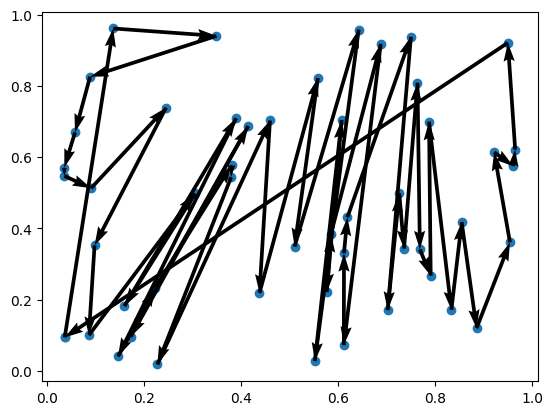

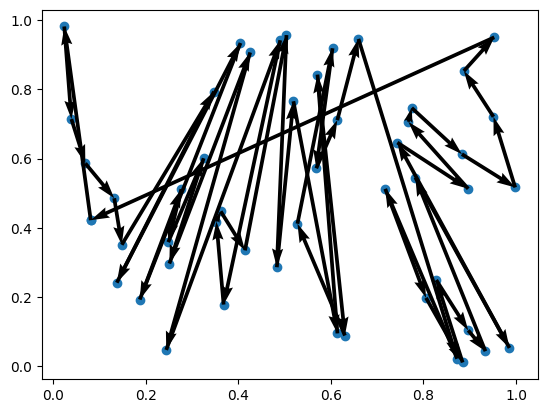

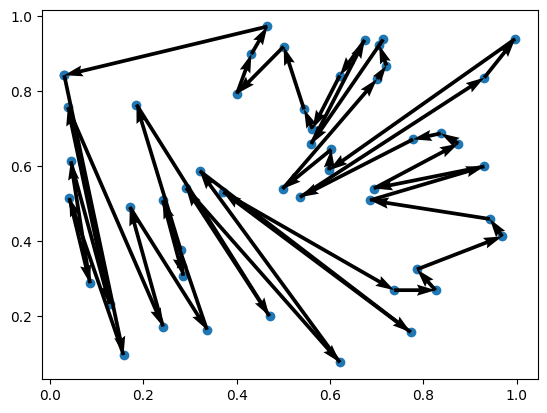

In [3]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
72        Modules in train mode
68        Modules in eval mode


/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/ethan/miniconda3/envs/llm4co/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 196/196 [00:08<00:00, 22.60it/s, v_num=1, train/reward=-7.29, train/loss=0.138]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 196/196 [00:10<00:00, 18.89it/s, v_num=1, train/reward=-6.70, train/loss=-0.681, val/reward=-6.70]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 196/196 [00:08<00:00, 23.78it/s, v_num=1, train/reward=-6.57, train/loss=-2.55, val/reward=-6.43] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 196/196 [00:08<00:00, 22.62it/s, v_num=1, train/reward=-6.57, train/loss=-2.55, val/reward=-6.38]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:09<00:00, 20.39it/s, v_num=1, train/reward=-6.57, train/loss=-2.55, val/reward=-6.38]


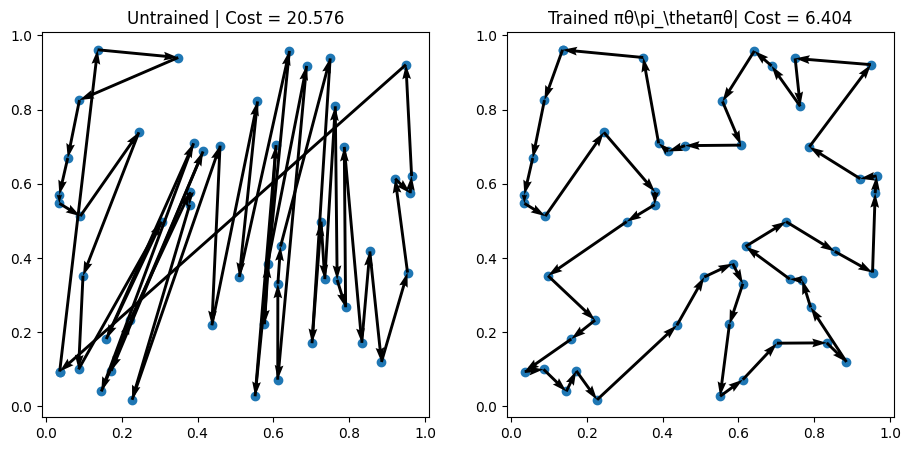

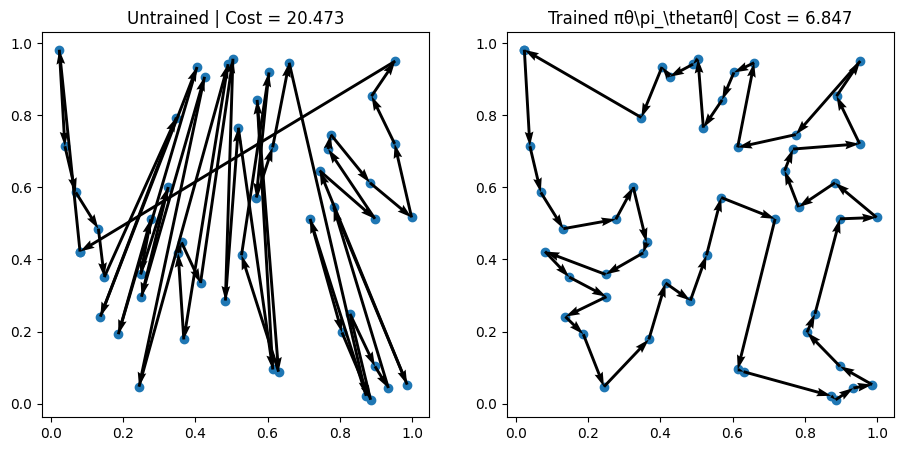

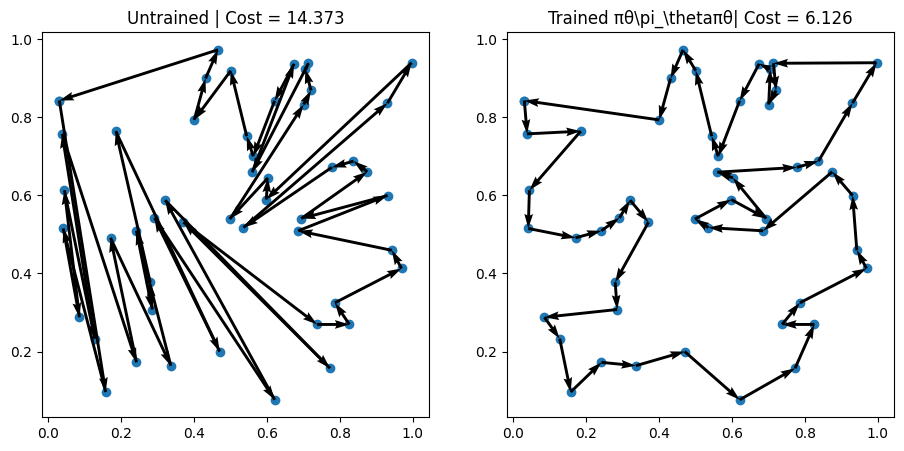

In [9]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained πθ\pi_\thetaπθ​" + f"| Cost = {-out['reward'][i].item():.3f}")

In [ ]:
# Optionally, save the checkpoint for later use (e.g. in tutorials/4-search-methods.ipynb)
trainer.save_checkpoint("tsp-quickstart.ckpt")